In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import armagarch as ag
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from arch import arch_model
from math import sqrt
import seaborn as sns
from pandas import Series
sns.set()


In [69]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [160]:
sp_futures = pd.read_csv("S&P500FuturesHistoricalData.csv")
sp_futures = sp_futures[['Date', 'Price', 'Change %']]
size = int(len(sp_futures)*0.8)
df_futures = sp_futures # df_futures, df_futures_test = sp_futures.iloc[:size], sp_futures.iloc[size:]
df_futures['Price'] = [float(x.replace(',', '')) for x in df_futures['Price']]
df_futures['Change %'] = [float(x.strip('%')) for x in df_futures['Change %']]
df_futures.Date = pd.to_datetime(df_futures.Date, dayfirst = True)
df_futures['market_value_diff'] = difference(df_futures['Price'])
# df_futures['returns_diff'] = difference(df_futures['Change %'])
df_futures.set_index('Date', inplace=True)
df_futures.columns = [['market_value', 'returns', 'market_value_diff']]
df_futures

,market_value,returns,market_value_diff
Date,,,
2022-11-11,4000.25,0.99,-39.25
2022-10-11,3961.00,5.47,-205.50
2022-09-11,3755.50,-2.08,79.75
2022-08-11,3835.25,0.52,-20.00
2022-07-11,3815.25,0.95,-35.75
...,...,...,...
2012-11-16,1359.75,0.63,-8.50
2012-11-15,1351.25,-0.13,1.75
2012-11-14,1353.00,-1.31,18.00


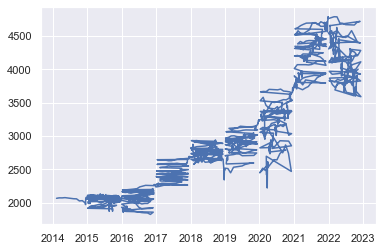

In [80]:
plt.plot(df_futures.index, df_futures['market_value'])
plt.show()

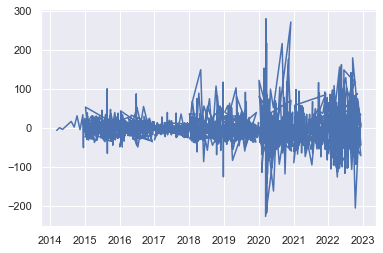

In [81]:
plt.plot(df_futures.index, df_futures['market_value_diff'])
plt.show()

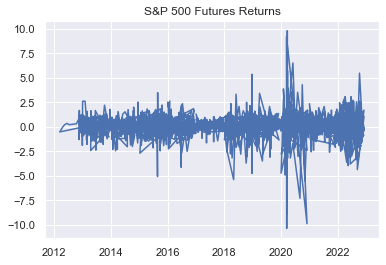

In [221]:
plt.plot(df_futures.index, df_futures['returns'])
plt.title("S&P 500 Futures Returns")
plt.show()

In [204]:
sp = pd.read_csv("S&P500HistoricalData.csv")
df = sp
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df['market_value'] = [float(x.replace(',', '')) for x in df['market_value']]
df['returns'] = [float(x.strip('%')) for x in df['returns']]
df['market_value_diff'] = difference(df['market_value'])
df.set_index('Date', inplace=True)
df = df[['market_value', 'returns', 'market_value_diff']]
df

,market_value,returns,market_value_diff
Date,,,
2022-11-11,3992.93,0.9241,-36.56
2022-10-11,3956.37,5.5434,-207.80
2022-09-11,3748.57,-2.0778,79.54
2022-08-11,3828.11,0.5598,-21.31
2022-07-11,3806.80,0.9614,-36.25
...,...,...,...
2012-11-16,1359.88,0.4840,-6.55
2012-11-15,1353.33,-0.1594,2.16
2012-11-14,1355.49,-1.3852,19.04


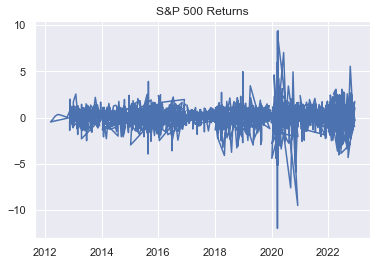

In [222]:
plt.plot(df.index, df['returns'])
plt.title("S&P 500 Returns")
plt.show()

In [161]:
def LLR_test(mod_1, mod_2, df_futures = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, df_futures).round(3)
    return p

In [217]:
def garch_summary(df, col, p, q, start=2):  
    model_garch = arch_model(df[col][start:], mean = "Constant", vol = "GARCH", p = p, q = q)
    results_garch = model_garch.fit(update_freq = 5)
    print(f"\n---- GARCH({p}, {q}) ----\n")
    print(results_garch.summary())
    return results_garch.aic

In [213]:
garch_summary(df_futures, "returns", 1, 1)
garch_summary(df_futures, "returns", 1, 2)
garch_summary(df_futures, "returns", 1, 3)
garch_summary(df_futures, "returns", 2, 1)
garch_summary(df_futures, "returns", 3, 1)


Iteration:      5,   Func. Count:     39,   Neg. LLF: 3194.937135187838
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3190.509052455229
            Iterations: 8
            Function evaluations: 56
            Gradient evaluations: 8

---- GARCH(1, 1) ----

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           ('returns',)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3190.51
Distribution:                  Normal   AIC:                           6389.02
Method:            Maximum Likelihood   BIC:                           6412.53
                                        No. Observations:                 2638
Date:                Mon, Nov 14 2022   Df Residuals:                     2637
Time:                        18:21:44   Df Model:                

6366.067729445565

In [226]:
aic_df_futures = []
min_aic_futures = [float("inf"), 0, 0]
for p in range(1,4):
    for q in range(1,4):
        aic = garch_summary(df_futures, "returns", p, q)
        if aic < min_aic_futures[0]:
            min_aic_futures = [aic, p, q]
        aic_df_futures.append(aic)
min_aic_futures

Iteration:      5,   Func. Count:     39,   Neg. LLF: 3194.937135187838
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3190.509052455229
            Iterations: 8
            Function evaluations: 56
            Gradient evaluations: 8

---- GARCH(1, 1) ----

                     Constant Mean - GARCH Model Results                      
Dep. Variable:           ('returns',)   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3190.51
Distribution:                  Normal   AIC:                           6389.02
Method:            Maximum Likelihood   BIC:                           6412.53
                                        No. Observations:                 2638
Date:                Mon, Nov 14 2022   Df Residuals:                     2637
Time:                        21:30:33   Df Model:                

[6364.36435993393, 2, 1]

In [228]:
aic_df = []
min_aic = [float("inf"), 0, 0]
for p in range(1,4):
    for q in range(1,4):
        aic = garch_summary(df, "returns", p, q)
        if aic < min_aic[0]:
            min_aic = [aic, p, q]
        aic_df.append(aic)
min_aic

Iteration:      5,   Func. Count:     39,   Neg. LLF: 3312.2557543835487
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3097.8314089310848
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 9

---- GARCH(1, 1) ----

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3097.83
Distribution:                  Normal   AIC:                           6203.66
Method:            Maximum Likelihood   BIC:                           6226.99
                                        No. Observations:                 2517
Date:                Mon, Nov 14 2022   Df Residuals:                     2516
Time:                        21:32:08   Df Model:              

[6180.292788762512, 2, 1]

In [44]:
# load data from KennethFrench library
# ff = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench')
# ff = ff[0]

# define mean, vol and distribution
# meanMdl = ag.ARMA(order = {'AR':1,'MA':0})
# volMdl = ag.garch(order = {'p':1,'q':1})
# distMdl = ag.normalDist()

# create a model
# model = ag.empModel(sp_futures['Price'].to_frame(), meanMdl, volMdl, distMdl)
# model = ag.empModel(ff['Mkt-RF'].to_frame(), meanMdl, volMdl, distMdl)

# fit model
# model.fit()

# get the conditional mean
# Ey = model.Ey

# get conditional variance
# ht = model.ht
# cvol = np.sqrt(ht)

# get standardized residuals
# stres = model.stres

# make a prediction of mean and variance over next 3 days.
# pred = model.predict(nsteps = 3)

# pred